In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_N = 36               # forecast periods
FC_STRIDE = 10
FC_START = "19580101"   # period at which to split training and validation dataset
EPOCH = 300         # for testing or debugging, rather than real forecasts, 
                  # set EPOCH to a low value like 3; for the real deal: 300 
                  # 300 will take as much as 30 - 50 minutes of processing time
# TCN specific
DROP = 0.1
LEARN = 0.001

In [14]:
## load data
ts = AirPassengersDataset().load()

series = ts  
df = ts.pd_dataframe()
df

component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [15]:
# analyze its seasonality

is_seasonal, periodicity = check_seasonality(ts, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 12.0
periodicity (~years) : 1.0


In [16]:
# split training vs test dataset
train, val = ts.split_after(pd.Timestamp(FC_START))

In [17]:
# normalize the time series

trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

In [18]:
# create month and year covariate series

year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=ts.freq_str, 
        periods=1000),
    attribute='year', 
    one_hot=False)
year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series, 
    attribute='month', 
    one_hot=True)

covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))

In [24]:
# set up, fit, run, plot, and evaluate the RNN model

def run_RNN(flavor, ts, train, val):

    # set the model up
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=periodicity,        
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)

    # compute N predictions
    pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

    # plot predictions vs actual
    plot_fitted(pred, ts, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]


# set up, fit, run, plot, and evaluate the TCN model

def run_TCN():

    model_TCN = TCNModel(
        input_chunk_length=FC_N+1,
        output_chunk_length=FC_N, 
        n_epochs=EPOCH,
        dropout=DROP,
        dilation_base=2,
        weight_norm=True,
        batch_size=16,
        kernel_size=5,
        num_filters=3,
        optimizer_kwargs={'lr': LEARN},
        log_tensorboard=True,
        force_reset=True,
        random_state=42)


    t_start =  time.perf_counter()
    print("\nbeginning the training of the TCN model")
    model_TCN.fit(
                series=train_trf,
                past_covariates=cov_train,
                val_series=val_trf,
                val_past_covariates=cov_val,
                verbose=True)
    res_time = time.perf_counter() - t_start
    print("training of the TCN has completed: ", f'{res_time:.2f} sec')


    # compute N predictions
    #pred = model_TCN.predict(FC_N, past)
    pred = model_TCN.predict(12,
                series=train_trf,
                past_covariates=cov_train)

    # plot predictions vs actual
    plot_fitted(pred, ts_trf, "TCN")

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts_trf)    
    print("TCN:")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]

# helper function: fit the RNN model

def fit_it(model, train, val, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             future_covariates=covariates,
             val_series=val,
             val_future_covariates=covariates,
             verbose=False)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res


# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(12,5))
    act.plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend();
    
    
# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2, "se": res_sefc}
    return res_accuracy



beginning the training of the LSTM RNN:
training of the LSTM RNN has completed: 19.85 sec


Predicting: 0it [00:00, ?it/s]

LSTM : 
MAPE : 5.8213
RMSPE : 0.0750
RMSE : 0.0614
-R squared : -0.9144
se : 0.1834

beginning the training of the GRU RNN:
training of the GRU RNN has completed: 20.12 sec


Predicting: 0it [00:00, ?it/s]

GRU : 
MAPE : 4.5595
RMSPE : 0.0600
RMSE : 0.0502
-R squared : -0.9266
se : 0.2167

beginning the training of the Vanilla RNN:
training of the Vanilla RNN has completed: 14.21 sec


Predicting: 0it [00:00, ?it/s]

Vanilla : 
MAPE : 8.5659
RMSPE : 0.1087
RMSE : 0.0862
-R squared : -0.7692
se : 0.2359


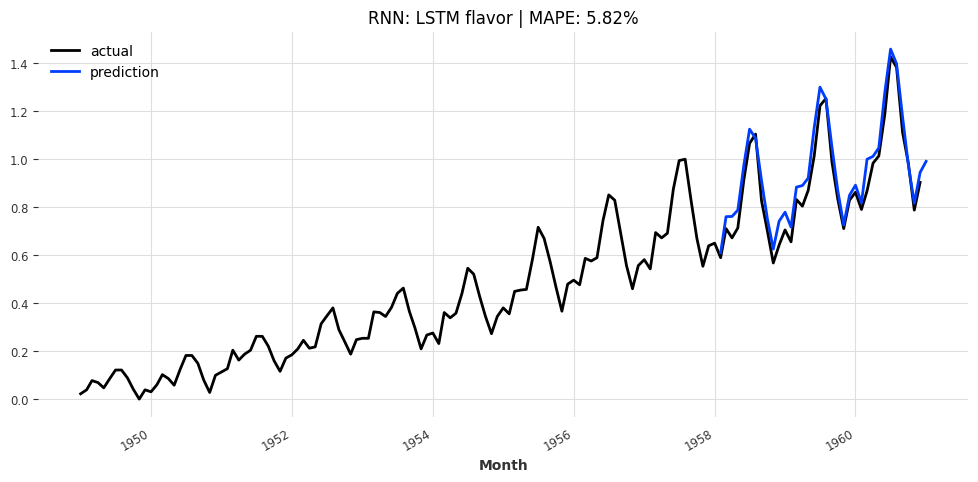

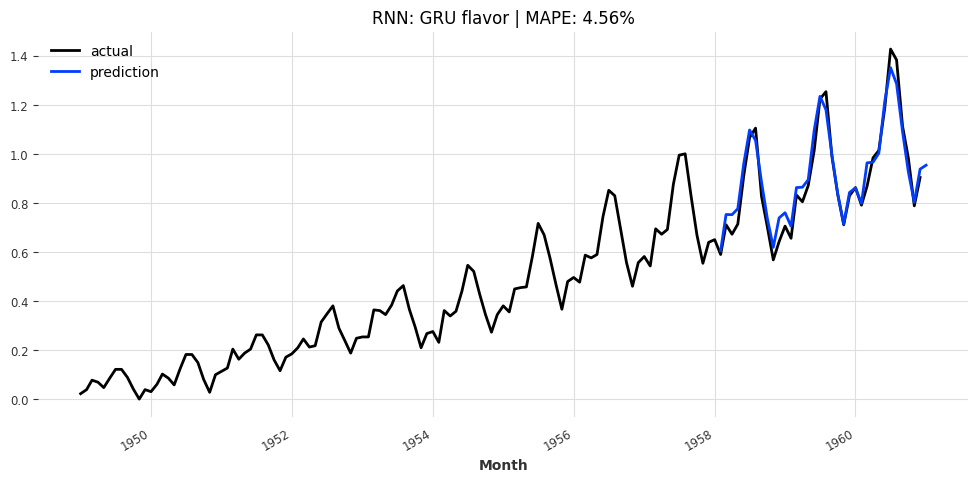

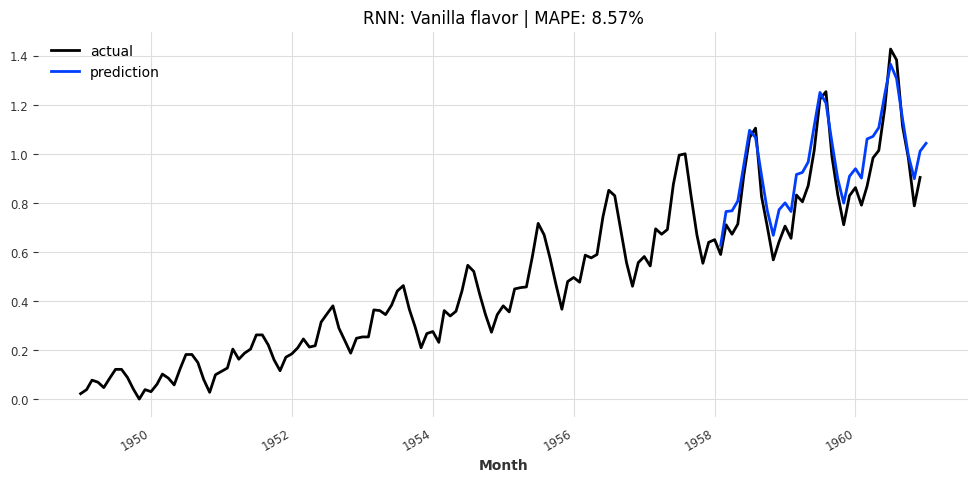

In [20]:
# run 3 different flavors of RNN on the time series:
flavors = ["TCN", "LSTM", "GRU", "RNN"]

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, ts_trf, train_trf, val_trf) for flv in flavors]

In [21]:
import darts
print (darts.__version__)

0.23.1
